In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
os.chdir(project_root)

if project_root not in sys.path:
    sys.path.append(project_root)

print("Current dir:", os.getcwd())

Current dir: /Users/ricardojuancardenesperez/tfg/framework


In [2]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

In [ ]:
from playground.readers.EnglishSentencesTextDataset.reader import Reader
from torch.utils.data import DataLoader

from playground.architectures.xLSTMSeq2seqBidirectionalAutoregressive import (
    Builder,
    Wrapper
)

from playground.trainers import TextAnnealingTrainer

In [4]:
from omegaconf import OmegaConf
from dacite import from_dict, Config as DaciteConfig
from xlstm import xLSTMBlockStackConfig

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Dataset

In [6]:
dataset = Reader()

In [7]:
for sample in dataset:
    print(sample)
    break

tensor([159, 137,  33, 289,  65, 244,  64, 119, 184,  78])


In [8]:
pad_idx = dataset.tokenizer.token2idx['<pad>']

In [9]:
def collate_fn(batch, max_len=30):
    global pad_idx
    batch = pad_sequence(batch, batch_first=True, padding_value=pad_idx)
    
    if batch.size(1) < max_len:
        pad_len = max_len - batch.size(1)
        pad_tensor = torch.full(
            (batch.size(0), pad_len, *batch.shape[2:]),
            fill_value=pad_idx,
            dtype=batch.dtype
        )
        batch = torch.cat([batch, pad_tensor], dim=1)
    
    return batch[:, :max_len]

In [10]:
from functools import partial

loader = DataLoader(dataset, batch_size=4, collate_fn=partial(collate_fn, max_len=30), shuffle=True)

In [11]:
for batch in loader:
    print(batch.shape)
    break

torch.Size([4, 30])


# Model

In [ ]:
path = 'experiments/notebooks/configs/'

def get_config(file):
    cfg = ''
    with open(path + file, 'r') as f:
        cfg += f.read()

    cfg = OmegaConf.create(cfg)
    return from_dict(data_class=xLSTMBlockStackConfig, data=OmegaConf.to_container(cfg), config=DaciteConfig(strict=True))


encoder_config = get_config('encoder.yml')
decoder_config = get_config('decoder.yml')

In [13]:
vocab_size = len(dataset.tokenizer.vocab)

In [14]:
builder = Builder()
model = builder.build(
    vocab_size,
    10,
    encoder_config,
    decoder_config
)

In [ ]:
wrapper = Wrapper(model)

In [16]:
x = torch.zeros(1, 12).long()
x, mu, sigma = wrapper(batch)
x.shape

torch.Size([4, 30, 342])

# Training

In [17]:
criteria = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
trainer = TextAnnealingTrainer(wrapper, 
                      criteria, 
                      optimizer, 
                      epochs=200,
                      batch_size=loader.batch_size,
                      method='logistic',
                      k=0.003,
                      x0=2700)

In [19]:
model, metrics = trainer.train(loader, teacher_forcing=0.5, return_metrics=True)

Epoch: 0, Loss: 559.8569899338943, Model Loss: 5.596838565973135, KD Loss: 544.2967982658973, KD Weight: 0.00032707301435101727
Epoch: 1, Loss: 502.3649585430439, Model Loss: 5.021621282284077, KD Loss: 596.1335296630859, KD Weight: 0.0003535966648626083
Epoch: 2, Loss: 473.22174776517426, Model Loss: 4.73008628991934, KD Loss: 578.6156745323768, KD Weight: 0.00038227040110077037
Epoch: 3, Loss: 448.431883591872, Model Loss: 4.481812788889958, KD Loss: 630.0276172344501, KD Weight: 0.0004132683765895795
Epoch: 4, Loss: 424.67752662071814, Model Loss: 4.244069530413701, KD Loss: 627.4723041240985, KD Weight: 0.0004467788275907299
Epoch: 5, Loss: 403.5930621807392, Model Loss: 4.032712230315576, KD Loss: 693.1487696721003, KD Weight: 0.0004830052079365387
Epoch: 6, Loss: 384.98878126878003, Model Loss: 3.8467788696289062, KD Loss: 618.4845674954928, KD Weight: 0.0005221674146441193
Epoch: 7, Loss: 369.1025907076322, Model Loss: 3.6877692754452047, KD Loss: 598.9634469839243, KD Weight: 0

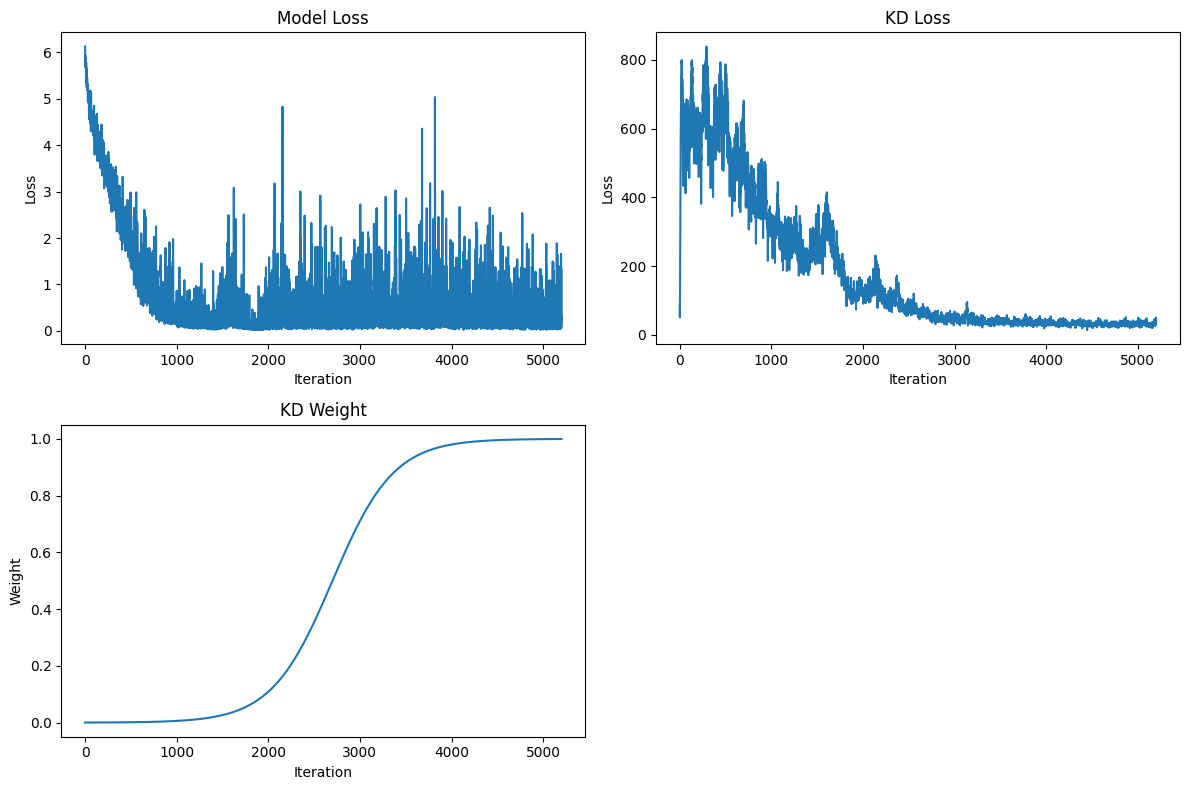

In [20]:
epochs = list(range(1, len(metrics['model_loss']) + 1))

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(epochs, metrics['model_loss'])
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')

axes[0, 1].plot(epochs, metrics['kd_loss'])
axes[0, 1].set_title('KD Loss')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Loss')

axes[1, 0].plot(epochs, metrics['kd_weight'])
axes[1, 0].set_title('KD Weight')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Weight')

axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Performance

In [27]:
def transform_to_text(output):
    return ' '.join(dataset.tokenizer.decode(output.numpy().tolist()[0]))

In [28]:
count = 10
results = {'input': [], 'output': []}

for sentence in dataset:
    input = sentence.unsqueeze(0)

    output, mu, sigma = model(input)
    output = output.argmax(dim=-1)
    
    input = transform_to_text(input)
    output = transform_to_text(output)

    results['input'].append(input)
    results['output'].append(output)

    if count == 0:
        break

    count -= 1

In [29]:
results

{'input': ['I usually get up around seven in the morning <eos>',
  'She forgot to bring her umbrella again <eos>',
  'We were talking about the trip last night <eos>',
  'He always leaves his keys on the kitchen table <eos>',
  'They decided to try a new restaurant downtown <eos>',
  'Are you going to the meeting this afternoon <eos>',
  'I haven’t seen him since last summer <eos>',
  'The coffee machine stopped working yesterday <eos>',
  'She’s been learning French for a few months <eos>',
  'Let me know if you need any help with that <eos>',
  'He’s planning to move to a new apartment soon <eos>'],
 'output': ['I haven’t had breakfast yet <eos> at the event <eos> weekend <eos> weekend <eos> <eos> weekend <eos> weekend <eos> <eos> weekend <eos> weekend <eos> <eos> weekend <eos> weekend <eos> <eos>',
  'She’s planning a trip to Europe <eos> dog <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>',
  'We we

# Interpolation

In [ ]:
z1 = torch.randn(1, 10)
z2 = torch.randn(1, 10)

In [ ]:
output1 = model.model.decoder(z1)
output2 = model.model.decoder(z2)

output1 = output1.argmax(dim=-1)
output2 = output2.argmax(dim=-1)

output1 = transform_to_text(output1)
output2 = transform_to_text(output2)

In [ ]:
print("First sentence:", output1.split('<eos>')[0])
print("Second sentence:", output2.split('<eos>')[0])

First sentence: They’ve been working on that for hours 
Second sentence: They always complaining about the weather 


In [ ]:
num_steps = 10

for alpha in torch.linspace(0, 1, steps=num_steps):
    z_interp = (1 - alpha) * z1 + alpha * z2
    output = model.model.decoder(z_interp)
    output = output.argmax(dim=-1)
    text = transform_to_text(output)
    print(f"alpha={alpha:.2f} →", text.split('<eos>')[0])

alpha=0.00 → They’ve been working on that for hours 
alpha=0.11 → They’ve been working on that for hours 
alpha=0.22 → I was work from home on Fridays 
alpha=0.33 → I was work from home on Fridays 
alpha=0.44 → I was work from home on Fridays 
alpha=0.56 → I couldn’t understand what he was saying 
alpha=0.67 → They always go for a walk after dinner 
alpha=0.78 → They always go for a walk after dinner 
alpha=0.89 → They always go for a walk after dinner 
alpha=1.00 → They always complaining about the weather 
